In [1]:
import os, glob, shutil
import urllib.request as r

def data_yuklab_olish(saqlash_uchun_papka, data_nomi = "rice_leaf_disease"): 
    
    data_nomlari = ["salaries", "exams", "college", "cars", "mall", "customers", "humanitarian", "rice_leaf_disease", "lentils"]
    assert data_nomi in data_nomlari, f"Mavjud bo'lgan dataset {data_nomlari} dan birini kiriting!"
    
    if data_nomi == "rice_leaf_disease": url = "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset"
    elif data_nomi == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    
    # Download from the checkpoint path
    if os.path.isfile(f"{saqlash_uchun_papka}/{data_nomi}.csv") or os.path.isdir(f"{saqlash_uchun_papka}/{data_nomi}"): print(f"Dataset yuklab olingan. {saqlash_uchun_papka}/{data_nomi} papkasini ni tekshiring."); pass

    # If the checkpoint does not exist
    else: 
        full_path = f"{saqlash_uchun_papka}/{data_nomi}"
        ds_nomi = url.split("/")[-1]
        os.makedirs(f"{saqlash_uchun_papka}/{ds_nomi}", exist_ok = True)
        
        print("Datani yuklash boshlanmoqda...")

        # Download the dataset
        os.system(f"{url} -p {full_path}")
        shutil.unpack_archive(f"{full_path}/{ds_nomi}.zip", f"{saqlash_uchun_papka}/{ds_nomi}")
        os.remove(f"{full_path}/{ds_nomi}.zip")
        os.rename(f"{saqlash_uchun_papka}/{ds_nomi}", f"{saqlash_uchun_papka}/{data_nomi}")
        print(f"Tanlangan dataset {saqlash_uchun_papka}/{data_nomi} papkasiga yuklab olindi!")
    
data_yuklab_olish(saqlash_uchun_papka = "project2", data_nomi = "rice_leaf_disease")

Dataset yuklab olingan. project2/rice_leaf_disease papkasini ni tekshiring.


In [2]:
import os, torch
from torch.utils.data import Dataset, DataLoader, random_split
from glob import glob
from PIL import Image
from torchvision import transforms as T

class CustomDataset(Dataset):
    
    def __init__(self, data_yulagi, transformations = None):
        super().__init__()
        

        self.im_paths = glob(f"{data_yulagi}/*/*.jp*g")
        print(len(self.im_paths))
        self.transformations = transformations
        self.klass_nomlari = {}
        klass_qiymati = 0
        
        for idx, yulak in enumerate(self.im_paths):
            klass_nomi = self.get_cls_names(yulak, di_uchun = True)
            if klass_nomi not in self.klass_nomlari: self.klass_nomlari[klass_nomi] = klass_qiymati; klass_qiymati += 1
            
            #print(f"Number of classes: {len(self.klass_nomlari)}")
            #print("Class names:", self.klass_nomlari)
            #for im_path in self.im_paths:
            #    im = Image.open(im_path)
            #    print(f"Image: {im_path}, Number of channels: {im.mode}")
        
    def __len__(self): return len(self.im_paths)

    def get_cls_names(self, yulak, di_uchun = False): return (Image.open(yulak), self.klass_nomlari[os.path.basename(os.path.dirname(yulak))]) if not di_uchun else os.path.basename(os.path.dirname(yulak)) 
        #return os.path.basename(yulak).split("_")[0]
     
    def __getitem__(self, idx): 
        
        rasm, javob = self.get_cls_names(self.im_paths[idx], di_uchun = False)
        if self.transformations: rasm = self.transformations(rasm)
        
        return rasm, javob
    
        
data_yulagi = "../Downloads/project2/rice-leaf-disease-classification-dataset/Rice Leaf  Disease Dataset"
#tfs = T.Compose([T.Resize((224, 224), interpolation=Image.BILINEAR), T.ToTensor()])
tfs = T.Compose([T.Resize((224, 224)), T.ToTensor()])
model = CustomDataset(data_yulagi = data_yulagi, transformations = tfs)    
klass_nomlari = model.klass_nomlari
print(klass_nomlari)
model[300][0].shape

591
{'Brown Spot': 0, 'False smut': 1, 'Healthy': 2, 'Material Leaf Blight': 3, 'Rice Blast': 4, 'sheath_blight': 5, 'Stem rot': 6, 'Tungro': 7}


torch.Size([3, 224, 224])

In [3]:
from torch.utils.data import DataLoader, random_split, Dataset

tr_length = len(model)
tr_len = int(tr_length * 0.9)
val_len = int(tr_length * 0.05)
ts_len = tr_length - tr_len - val_len

tr_ds, val_ds, ts_ds = random_split(model, [tr_len, val_len, ts_len])

print(f"Train datasetda -> {len(tr_ds)} ta data bor")
print(f"Validation datasetda -> {len(val_ds)} ta data bor")
print(f"Test datasetda -> {len(ts_ds)} ta data bor")

Train datasetda -> 531 ta data bor
Validation datasetda -> 29 ta data bor
Test datasetda -> 31 ta data bor


In [4]:
bs = 16
tr_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, num_workers = 0)
val_dl = DataLoader(val_ds, batch_size = bs, shuffle = False, num_workers = 0)
ts_dl = DataLoader(ts_ds, batch_size = bs, shuffle = False, num_workers = 0)
print(len(tr_dl))
print(len(val_dl))
print(len(ts_dl))

34
2
2


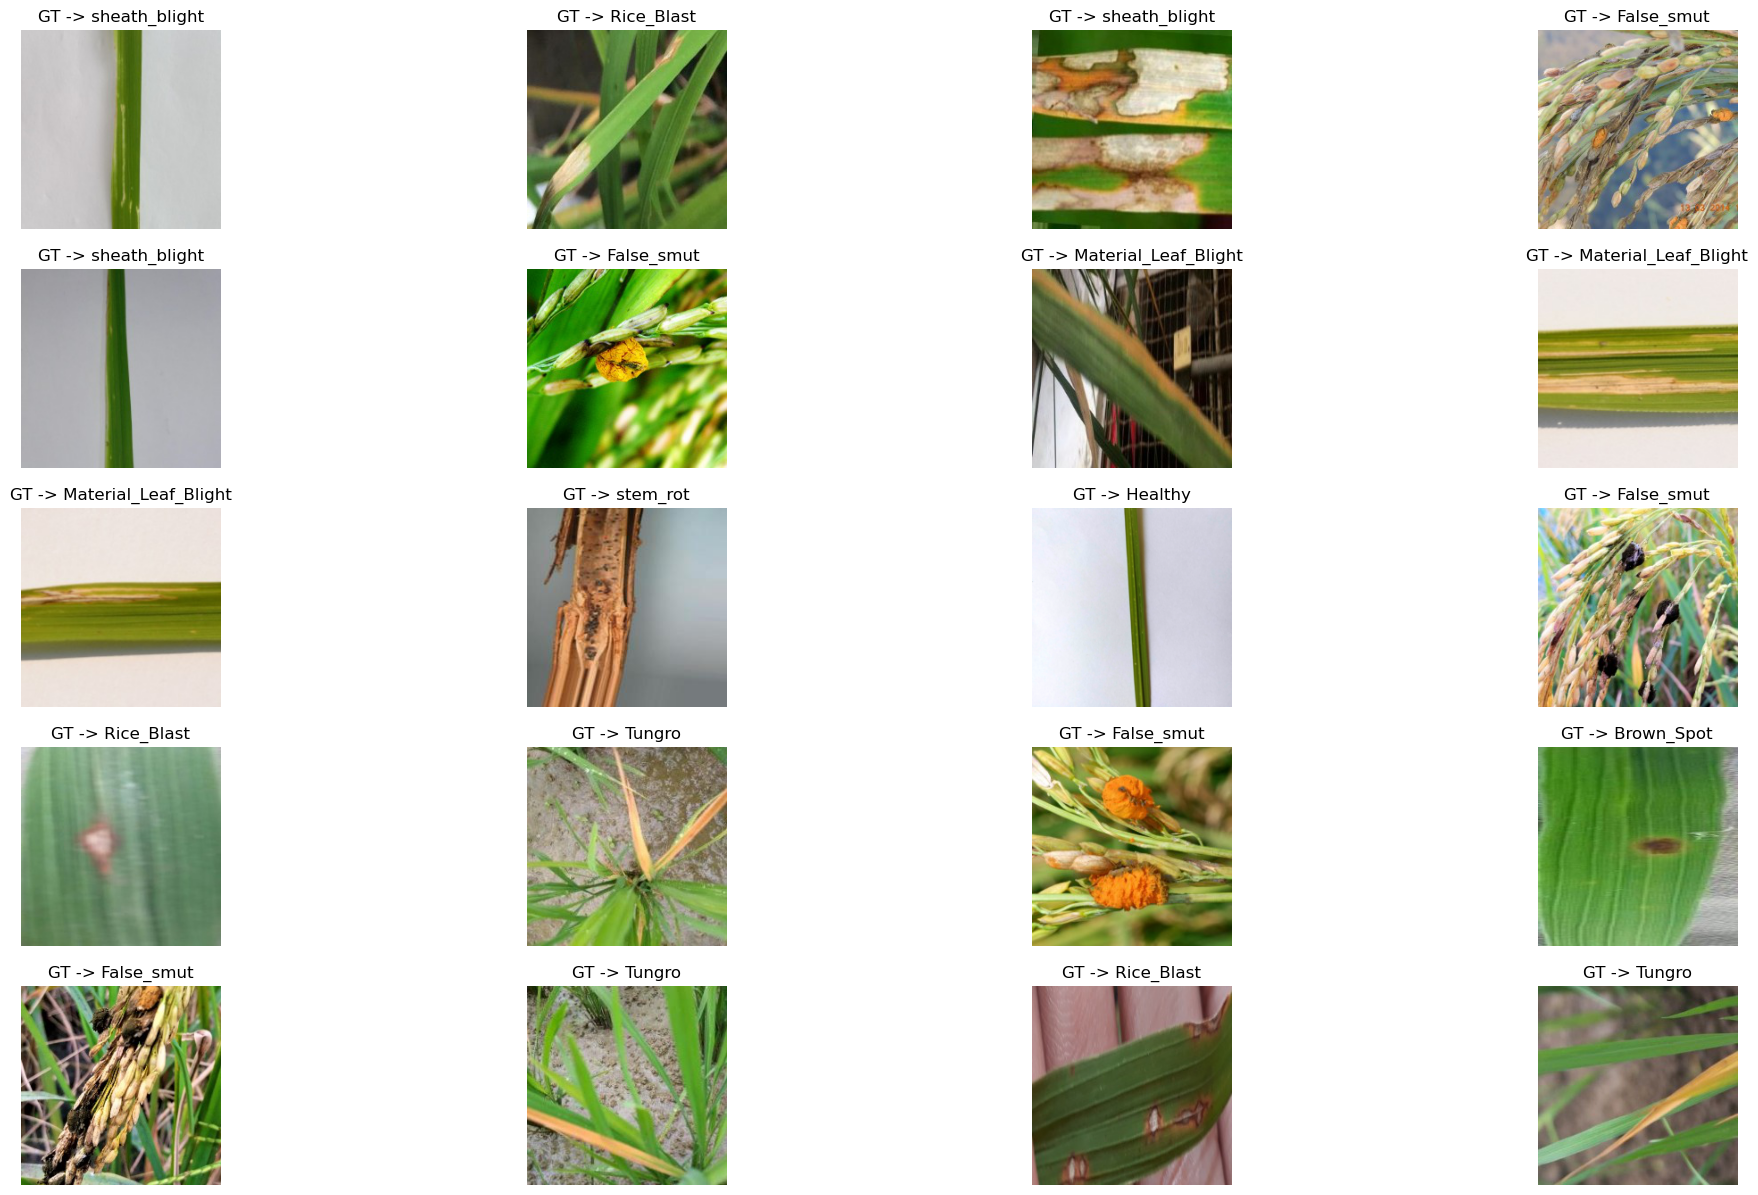

In [5]:
from matplotlib import pyplot as plt
import random
klass_nomlari = ['Brown_Spot', 'False_smut', 'Healthy', 'Material_Leaf_Blight', 'Rice_Blast', 'sheath_blight', 'stem_rot', 'Tungro']

def visualize(data, rasmlar_soni, qatorlar, klass_nomlari = None):

    plt.figure(figsize = (25, 15))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(rasmlar_soni)]
    inversion_tfs = T.Compose([T.Normalize(mean = [0.], std = [1/0.4]), T.Normalize(mean = [-0.1], std = [1])])

    for idx, indeks in enumerate(indekslar):

        rasm, javob = data[indeks]
        plt.subplot(qatorlar, rasmlar_soni // qatorlar, idx + 1)
        #print(torch.unique(rasm))
        plt.imshow(inversion_tfs(rasm).cpu().permute(1,2,0).numpy().astype("uint16"), cmap = "gray")
        plt.imshow(((rasm)*255).cpu().permute(1,2,0).numpy().astype("uint16"), cmap = "gray")
        plt.axis("off")
        if klass_nomlari: plt.title(f"GT -> {klass_nomlari[javob]}")
        else: plt.title(f"GT -> {javob}")

visualize(data = tr_dl.dataset, rasmlar_soni = 20, qatorlar = 5, klass_nomlari = klass_nomlari)

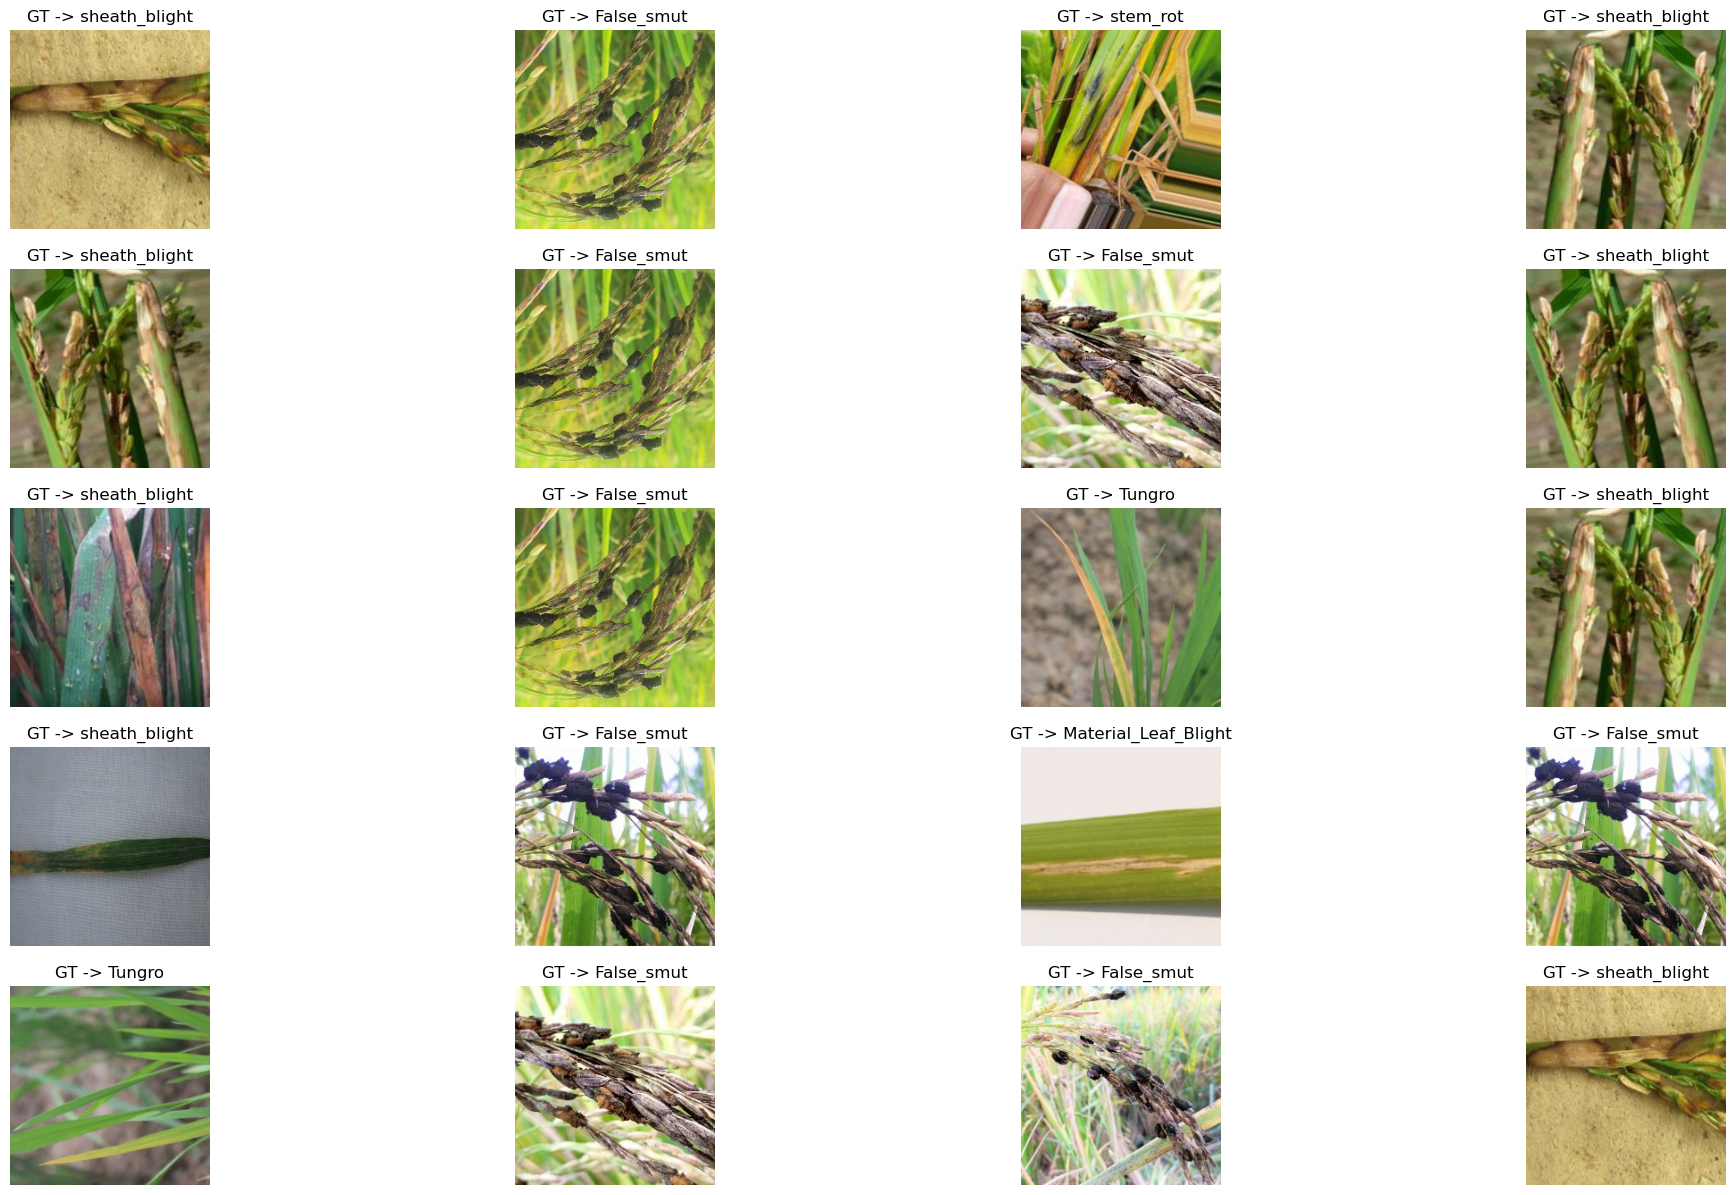

In [6]:
from matplotlib import pyplot as plt
import random
klass_nomlari = ['Brown_Spot', 'False_smut', 'Healthy', 'Material_Leaf_Blight', 'Rice_Blast', 'sheath_blight', 'stem_rot', 'Tungro']

def visualize(data, rasmlar_soni, qatorlar, klass_nomlari = None):

    plt.figure(figsize = (25, 15))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(rasmlar_soni)]
    inversion_tfs = T.Compose([T.Normalize(mean = [0.], std = [1/0.4]), T.Normalize(mean = [-0.1], std = [1])])

    for idx, indeks in enumerate(indekslar):

        rasm, javob = data[indeks]
        plt.subplot(qatorlar, rasmlar_soni // qatorlar, idx + 1)
        #print(torch.unique(rasm))
        plt.imshow(inversion_tfs(rasm).cpu().permute(1,2,0).numpy().astype("uint16"), cmap = "gray")
        plt.imshow(((rasm)*255).cpu().permute(1,2,0).numpy().astype("uint16"), cmap = "gray")
        plt.axis("off")
        if klass_nomlari: plt.title(f"GT -> {klass_nomlari[javob]}")
        else: plt.title(f"GT -> {javob}")

visualize(data = val_dl.dataset, rasmlar_soni = 20, qatorlar = 5, klass_nomlari = klass_nomlari)

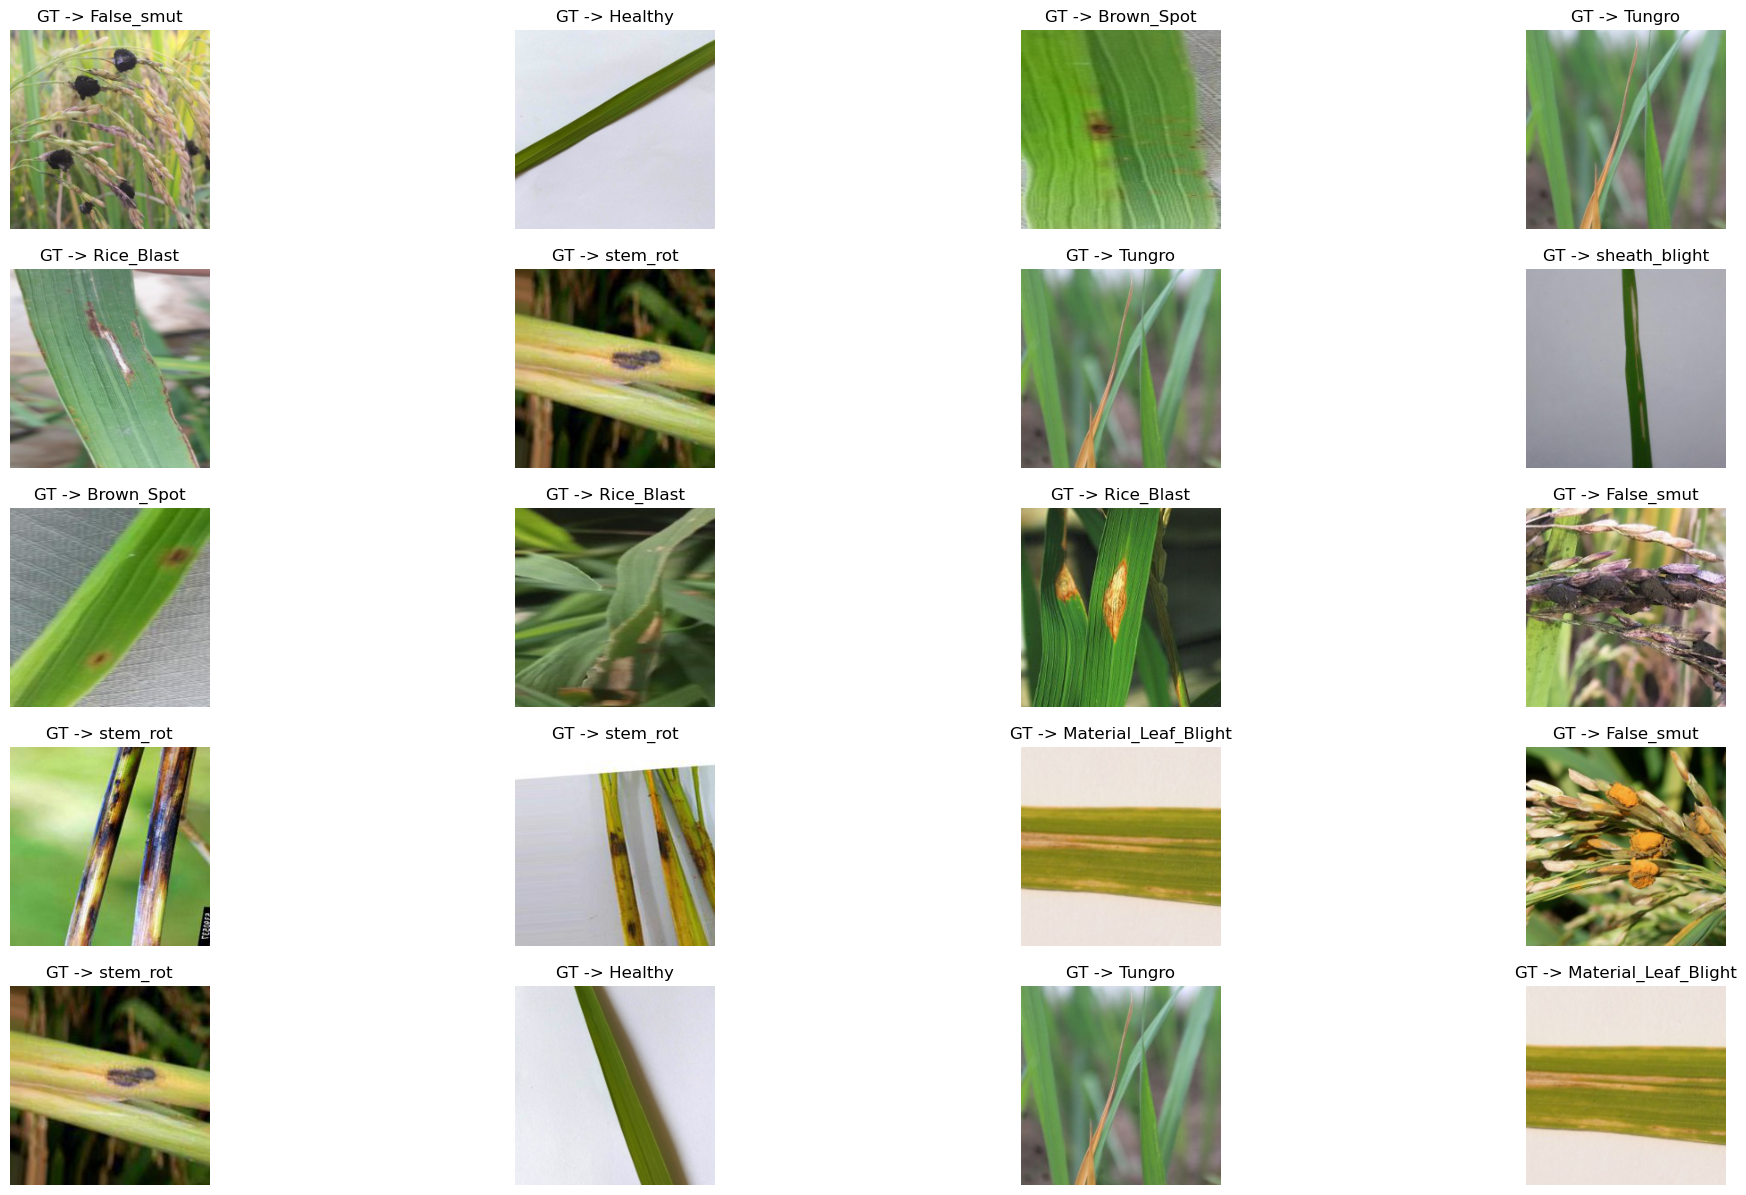

In [7]:
from matplotlib import pyplot as plt
import random
klass_nomlari = ['Brown_Spot', 'False_smut', 'Healthy', 'Material_Leaf_Blight', 'Rice_Blast', 'sheath_blight', 'stem_rot', 'Tungro']

def visualize(data, rasmlar_soni, qatorlar, klass_nomlari = None):

    plt.figure(figsize = (25, 15))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(rasmlar_soni)]
    inversion_tfs = T.Compose([T.Normalize(mean = [0.], std = [1/0.4]), T.Normalize(mean = [-0.1], std = [1])])

    for idx, indeks in enumerate(indekslar):

        rasm, javob = data[indeks]
        plt.subplot(qatorlar, rasmlar_soni // qatorlar, idx + 1)
        #print(torch.unique(rasm))
        plt.imshow(inversion_tfs(rasm).cpu().permute(1,2,0).numpy().astype("uint16"), cmap = "gray")
        plt.imshow(((rasm)*255).cpu().permute(1,2,0).numpy().astype("uint16"), cmap = "gray")
        plt.axis("off")
        if klass_nomlari: plt.title(f"GT -> {klass_nomlari[javob]}")
        else: plt.title(f"GT -> {javob}")

visualize(data = ts_dl.dataset, rasmlar_soni = 20, qatorlar = 5, klass_nomlari = klass_nomlari)

In [19]:
import timm
model = timm.create_model("resnet18", pretrained = True, num_classes = 8)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [20]:
epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu" 
model.to(device)
loss_fc = torch.nn.CrossEntropyLoss()
optimazer = torch.optim.Adam(params = model.parameters(), lr = 1e-3)

In [21]:
import numpy as np
from tqdm import tqdm
def train(model, tr_dl, val_dl, epochs, device, loss_fc, opt, save_prefix):
  tr_acc_sc_ = []
  val_acc_sc_, val_epoc_loss_ = [],[]
  tr_total =0
  best_loss = np.inf
  decrease, not_improve, early_stop_threshold= 1,0,5

  print("Train is starting .....")

  for epoc in range(epochs):
      print(f"{epoc+1}- epoc is starting..")
      count=0
      tr_acc_sr, tr_total =0,0

      for idx, batch in tqdm(enumerate(tr_dl)):
          ims, gts = batch
          ims = ims.to(device)
          gts = gts.to(device)

          pred = model(ims)
          loss = loss_fc(pred, gts)

          tr_total+=ims.shape[0]
          pred_class = torch.argmax(pred, dim =1)
          count+=1
          tr_acc_sr+= (pred_class==gts).sum().item()

          optimazer.zero_grad()
          loss.backward()
          optimazer.step()

      model.eval()
      with torch.no_grad():
          val_acc_sc = 0
          val_total =0
          val_epoc_loss = 0

          for idx, batch in enumerate(val_dl):
              ims, gts = batch
              ims, gts = ims.to(device), gts.to(device)

              val_total+=ims.shape[0]

              pred = model(ims)


              pred_class = torch.argmax(pred, dim=1)
              val_acc_sc+=(pred_class==gts).sum().item()
              loss = loss_fc(pred, gts)
              val_epoc_loss+=loss.item()

              tr_ACC_SR = tr_acc_sr/tr_total
              VAL_acc_sc = val_acc_sc/val_total
              VAL_epoc_loss = val_epoc_loss/len(val_dl)


          print(f"{epoc+1} is finished..")
          print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
          print(f"{epoc+1} - epoc result:\n")
          print(f"{epoc+1}- epoc Train Accurancy score        -> {tr_ACC_SR:.3f}")
          print(f"{epoc+1}- epoc Validation Accurancy score   -> {VAL_acc_sc:.3f}")
          print(f"{epoc+1}- epoc Validation loss score        -> {VAL_epoc_loss:.3f}\n\n")


          tr_acc_sc_.append(tr_ACC_SR)
          val_acc_sc_.append(VAL_acc_sc)
          val_epoc_loss_.append(VAL_epoc_loss)

      

          if VAL_epoc_loss < best_loss:
              os.makedirs("best_model2", exist_ok=True)
              best_loss = VAL_epoc_loss
              torch.save(model, f"best_model2/{save_prefix}_best_model.pth")

  return {"tr_acc_sc": tr_acc_sc_, "val_acc_sc": val_acc_sc_, "val_epoc_loss": val_epoc_loss_}

In [22]:
result = train(model=model, tr_dl=tr_dl, val_dl=val_dl, epochs=10, device=device,
               loss_fc=loss_fc, opt=optimazer, save_prefix="rice_leaf_disease")

Train is starting .....
1- epoc is starting..


34it [00:08,  4.08it/s]


1 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1 - epoc result:

1- epoc Train Accurancy score        -> 0.294
1- epoc Validation Accurancy score   -> 0.241
1- epoc Validation loss score        -> 1.801


2- epoc is starting..


34it [00:08,  4.09it/s]


2 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
2 - epoc result:

2- epoc Train Accurancy score        -> 0.469
2- epoc Validation Accurancy score   -> 0.552
2- epoc Validation loss score        -> 1.210


3- epoc is starting..


34it [00:08,  4.02it/s]


3 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
3 - epoc result:

3- epoc Train Accurancy score        -> 0.599
3- epoc Validation Accurancy score   -> 0.517
3- epoc Validation loss score        -> 1.353


4- epoc is starting..


34it [00:08,  4.13it/s]


4 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
4 - epoc result:

4- epoc Train Accurancy score        -> 0.603
4- epoc Validation Accurancy score   -> 0.621
4- epoc Validation loss score        -> 0.784


5- epoc is starting..


34it [00:08,  4.12it/s]


5 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
5 - epoc result:

5- epoc Train Accurancy score        -> 0.670
5- epoc Validation Accurancy score   -> 0.586
5- epoc Validation loss score        -> 1.143


6- epoc is starting..


34it [00:08,  4.15it/s]


6 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
6 - epoc result:

6- epoc Train Accurancy score        -> 0.748
6- epoc Validation Accurancy score   -> 0.690
6- epoc Validation loss score        -> 0.699


7- epoc is starting..


34it [00:08,  4.03it/s]


7 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
7 - epoc result:

7- epoc Train Accurancy score        -> 0.750
7- epoc Validation Accurancy score   -> 0.621
7- epoc Validation loss score        -> 0.729


8- epoc is starting..


34it [00:08,  4.10it/s]


8 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
8 - epoc result:

8- epoc Train Accurancy score        -> 0.782
8- epoc Validation Accurancy score   -> 0.690
8- epoc Validation loss score        -> 0.643


9- epoc is starting..


34it [00:08,  4.07it/s]


9 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
9 - epoc result:

9- epoc Train Accurancy score        -> 0.791
9- epoc Validation Accurancy score   -> 0.759
9- epoc Validation loss score        -> 0.732


10- epoc is starting..


34it [00:08,  4.08it/s]


10 is finished..
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
10 - epoc result:

10- epoc Train Accurancy score        -> 0.829
10- epoc Validation Accurancy score   -> 0.862
10- epoc Validation loss score        -> 0.431




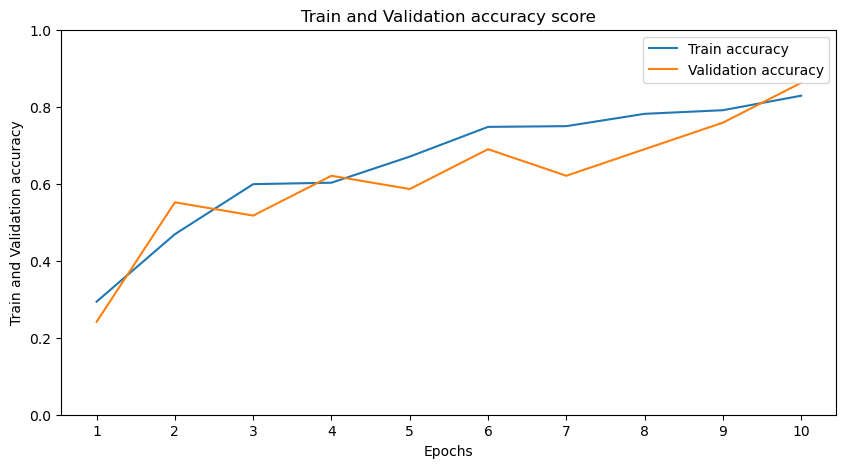

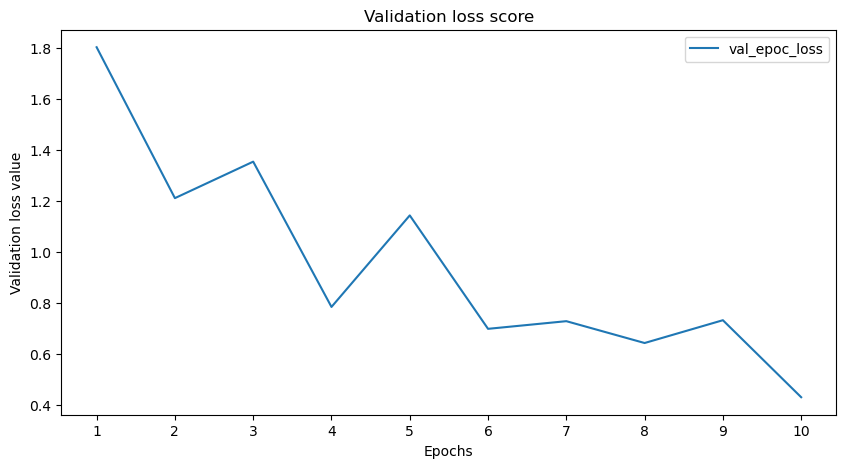

In [23]:
from matplotlib import pyplot as plt

class plot():
    def __init__(self, natija):
        
        plt.figure(figsize=(10, 5))
        plt.title("Train and Validation accuracy score")
        plt.xlabel("Epochs")
        plt.ylabel("Train and Validation accuracy")
        plt.plot(natija["tr_acc_sc"], label = "Train accuracy")
        plt.plot(natija["val_acc_sc"], label = "Validation accuracy")
        plt.xticks(np.arange(len(natija['val_acc_sc'])), [i for i in range(1, len(natija['val_acc_sc']) + 1)])
        plt.ylim(0, 1)
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10,5))
        plt.title("Validation loss score")
        plt.ylabel("Validation loss value")
        plt.xlabel("Epochs")
        plt.plot(natija["val_epoc_loss"], label = "val_epoc_loss")
        plt.xticks(np.arange(len(natija['val_epoc_loss'])), [i for i in range(1, len(natija['val_epoc_loss']) + 1)])
        plt.legend()
        plt.show()
plot(result)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([3, 224, 224])


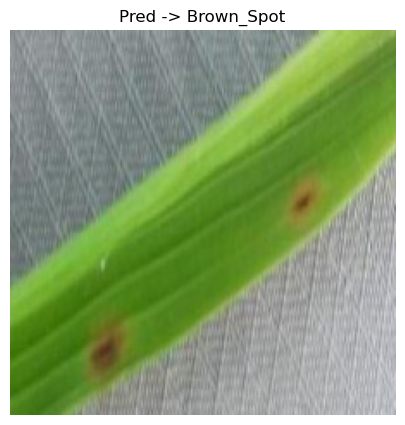

torch.Size([3, 224, 224])


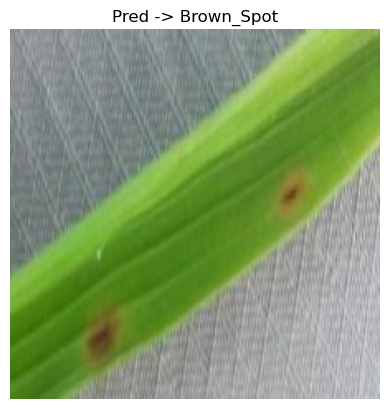

torch.Size([3, 224, 224])


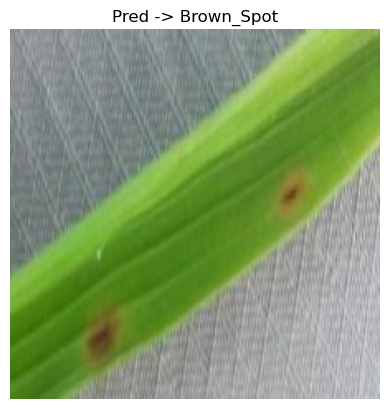

torch.Size([3, 224, 224])


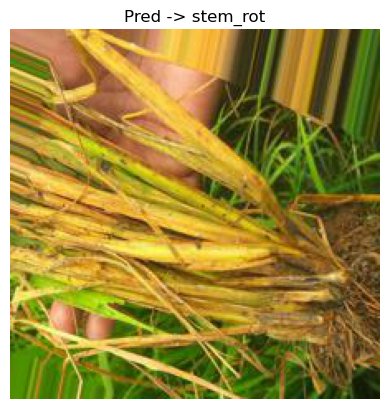

torch.Size([3, 224, 224])


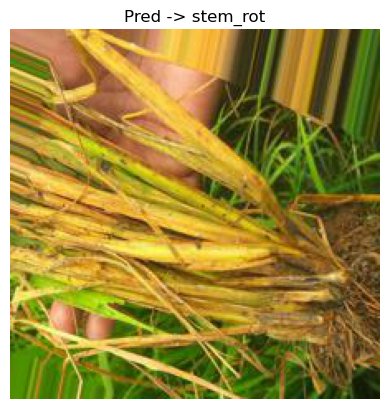

torch.Size([3, 224, 224])


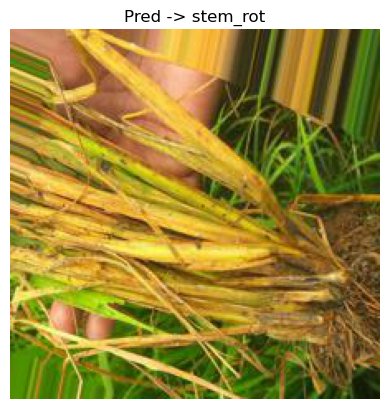

torch.Size([3, 224, 224])


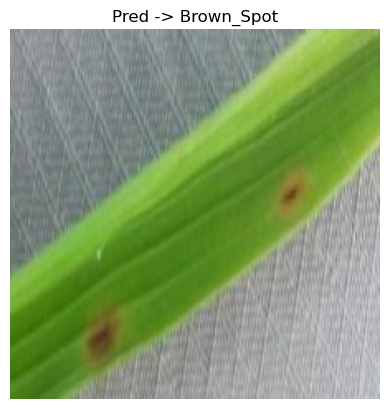

torch.Size([3, 224, 224])


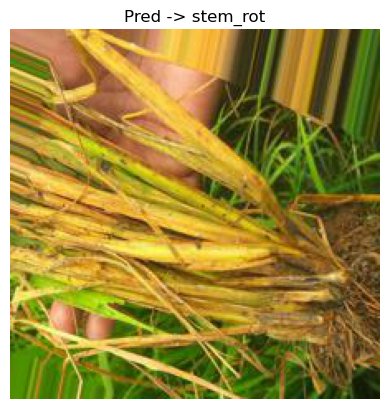

torch.Size([3, 224, 224])


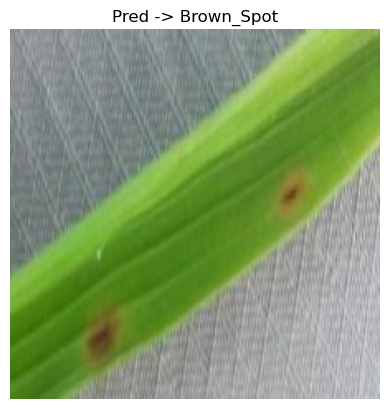

torch.Size([3, 224, 224])


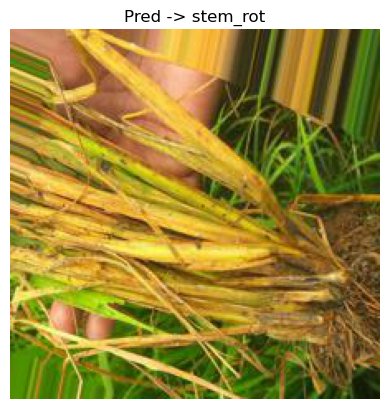

In [24]:
import random
def inference(data, rasmlar_soni, model, device, klass_nomi = None):
    bashoratlar = []
    rasmlar = []
    
    for idx, batch in enumerate(data):
        if idx == 10: break
        rasm, gt = batch
        print(type(rasm))
        rasm, gt = rasm.to(device), gt.to(device)
        bashorat = model(rasm)
        bashorat_cls = torch.argmax(bashorat, dim = 1)
        bashoratlar.append(bashorat_cls)
        rasmlar.append(rasm)
    
    plt.figure(figsize=(10, 5))
    indekslar = [random.randint(0, len(rasmlar)-1) for _ in range(rasmlar_soni)]
    
    for idx, indeks in enumerate(indekslar):
        rasm = rasmlar[indeks][1]
        print(rasm.shape)

        plt.imshow((rasm*255).cpu().permute(2,1,0).numpy().astype("uint8"))
        plt.axis("off")
        plt.title(f"Pred -> {klass_nomi[bashoratlar[indeks][1]]}")
        
            
        plt.show()

inference(data = ts_dl, model = model.to(device), device = device, rasmlar_soni = 10, klass_nomi = list(klass_nomlari))
model = torch.load("best_model2/rice_leaf_disease_best_model.pth")